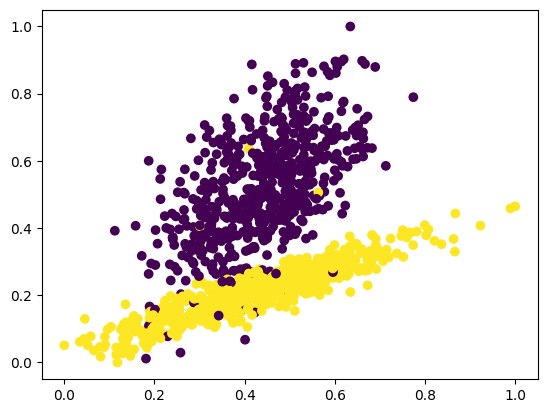

In [172]:
import copy
from tqdm import tqdm
import numpy as np
from sklearn.datasets import make_classification, make_blobs, make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg
import cvxopt
import cvxopt.solvers

x, y = make_classification(n_samples=1250, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=85)
# x, y = make_moons(n_samples=1250, random_state=23)

y[y == 0] = -1
x = MinMaxScaler().fit_transform(x)

xx, yy = np.meshgrid(np.arange(x.min() + x.min() * 0.05, x.max() + x.max() * 0.05, 0.025),
                     np.arange(x.min() + x.min() * 0.05, x.max() + x.max() * 0.05, 0.025))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=25)
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

In [173]:
class FuzzySVM:
    def __init__(self, c: int = 100, gamma: float = 0.5, treshold: float = 0.00001, membership_ranges: tuple = (-10, 0.5, 0.6, 10)):
        self.x_memberships = None
        self.C = c
        self.gamma = gamma
        self.support_vectors = None
        self.support_vectors_labels = None
        self.intercept_ = None
        self.alpha = None
        self.w = None
        self.membership = None
        self.alpha_vanilla = None
        self.treshold = treshold
        self.membership_ranges = membership_ranges

    def kernel_function(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)

    def fuzz_trapezoidal(self, x):

        a, b, c, d = self.membership_ranges

        if x <= a:
            return 0
        elif a < x <= b:
            return (x - a) / (b - a)
        elif b < x <= c:
            return 1
        elif c < x <= d:
            return (d - x) / (d - c)
        else:
            return 0

    def fit(self, x, y):

        self.x_memberships = np.zeros((len(x)))
        for idx in range(len(x)):
            self.x_memberships[idx] = self.fuzz_trapezoidal((idx/len(x)))

        print(self.x_memberships)
        n_samples, n_features = x.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel_function(x[i], x[j])

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), 'd')
        b = cvxopt.matrix(0.0)
        G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.diag(self.x_memberships))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        self.alpha = np.ravel(solution['x'])
        self.alpha_vanilla = copy.deepcopy(self.alpha)

        support_vector = self.alpha > self.treshold
        self.support_vectors = x[support_vector]
        self.support_vectors_labels = y[support_vector]

        K_idx = np.arange(len(self.alpha_vanilla))[support_vector]
        self.alpha = self.alpha_vanilla[support_vector]
        self.x_memberships = self.x_memberships[support_vector]

        self.intercept_ = 0
        for idx in range(len(self.alpha)):
            self.intercept_ += self.support_vectors_labels[idx]
            self.intercept_ -= np.sum(self.alpha[idx] * self.support_vectors_labels[idx] * K[K_idx[idx], support_vector])
        self.intercept_ /= len(self.alpha)

        self.w = np.zeros(n_features)
        for idx in range(len(self.alpha)):
            self.w += self.alpha[idx] * self.support_vectors_labels[idx] * self.support_vectors[idx]

    def predict(self, x):
        y_pred = []

        # for sample in x:
        #     y_pred.append(np.sign(np.dot(sample, self.w ) + self.intercept_))
        # return np.array(y_pred)

        for idx in tqdm(range(x.shape[0])):
            s = 0
            for a, sv_y, sv in zip(self.alpha, self.support_vectors_labels, self.support_vectors):
                s += a * sv_y * self.kernel_function(x[idx], sv)
            y_pred.append(np.sign(s + self.intercept_))
        return np.array(y_pred)

In [174]:
fuz = FuzzySVM(membership_ranges=(-1, 0.5, 0.6, 2))
fuz.fit(x_train, y_train)

[0.66666667 0.66733333 0.668      0.66866667 0.66933333 0.67
 0.67066667 0.67133333 0.672      0.67266667 0.67333333 0.674
 0.67466667 0.67533333 0.676      0.67666667 0.67733333 0.678
 0.67866667 0.67933333 0.68       0.68066667 0.68133333 0.682
 0.68266667 0.68333333 0.684      0.68466667 0.68533333 0.686
 0.68666667 0.68733333 0.688      0.68866667 0.68933333 0.69
 0.69066667 0.69133333 0.692      0.69266667 0.69333333 0.694
 0.69466667 0.69533333 0.696      0.69666667 0.69733333 0.698
 0.69866667 0.69933333 0.7        0.70066667 0.70133333 0.702
 0.70266667 0.70333333 0.704      0.70466667 0.70533333 0.706
 0.70666667 0.70733333 0.708      0.70866667 0.70933333 0.71
 0.71066667 0.71133333 0.712      0.71266667 0.71333333 0.714
 0.71466667 0.71533333 0.716      0.71666667 0.71733333 0.718
 0.71866667 0.71933333 0.72       0.72066667 0.72133333 0.722
 0.72266667 0.72333333 0.724      0.72466667 0.72533333 0.726
 0.72666667 0.72733333 0.728      0.72866667 0.72933333 0.73
 0.73066667 

In [175]:
y_pred = fuz.predict(x_test)

100%|██████████| 250/250 [00:00<00:00, 969.53it/s]


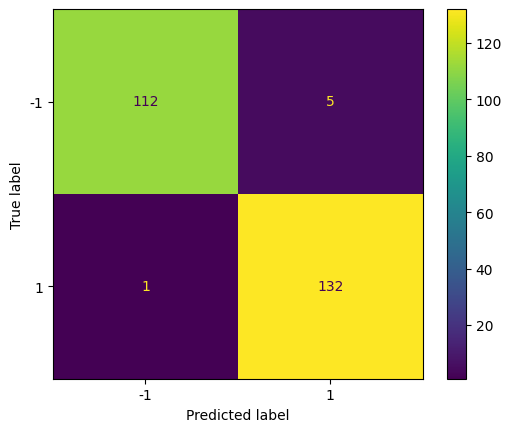

In [176]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [177]:
mesh_data = np.c_[xx.ravel(), yy.ravel()]
Z = fuz.predict(mesh_data).reshape(xx.shape)

100%|██████████| 1764/1764 [00:01<00:00, 989.49it/s] 


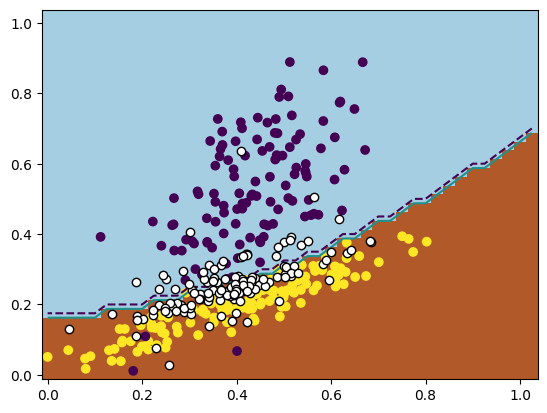

In [178]:
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(fuz.support_vectors[:, 0], fuz.support_vectors[:, 1], facecolors='white', zorder=10, edgecolors='k')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()

--------------------------------------------------------------------------------------------------------

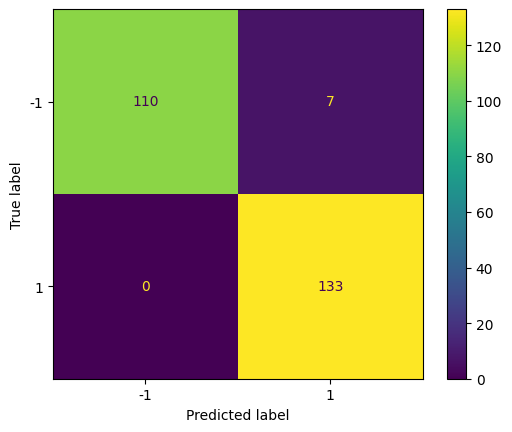

In [179]:
from sklearn.svm import SVC

model = SVC(C=100, kernel='rbf', gamma=0.5)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [180]:
mesh_data = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(mesh_data).reshape(xx.shape)

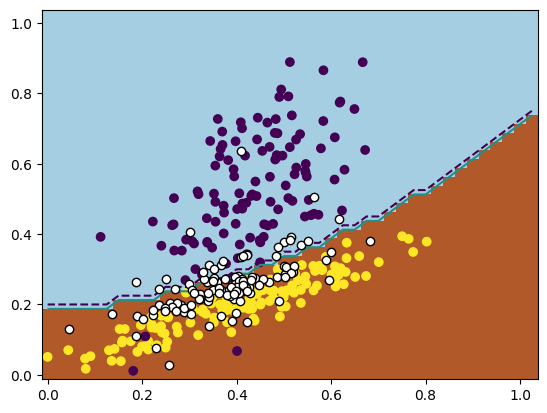

In [181]:
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], facecolors='white', zorder=10, edgecolors='k')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()

In [182]:
print(f' Number of sklearn support vectors: {len(model.support_vectors_)} \n Number of fuzzy support vectors: {len(fuz.support_vectors)}')

 Number of sklearn support vectors: 116 
 Number of fuzzy support vectors: 132
